In [1]:
import os
import pickle

import numpy as np
import pandas as pd

# viz goodies
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import squarify # for quilt plots

import cfrna_methods as toolkit 

# For editable text. 
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 15}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)

/Users/sevahn/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
revised = ['#ffd000',
 '#ff7b00',
 '#f25c54',
 '#d90368',
 '#ff637d',
 '#f88dad',
 '#d90429',
 '#ff5a5f',
 '#6d597a',
 '#219ebc',
 '#0077b6',
 '#90e0ef',
 '#caf0f8',
 '#62b6cb',
 '#A0CED9',
 '#bee9e8',
 '#0075a2',
 '#cae9ff',
 '#3e92cc',
 '#21897e',
 '#028090',
 '#68B0AB',"#05668d","#028090","#00a896","#02c39a","#f0f3bd"]
revised[0:7] = revised[5:7] + revised[0:5]

In [3]:
# normalized values
biofluid_pal = {}

biofluid_pal = {}
biofluid_pal['sediment'] = "#97D9E1"
biofluid_pal['supt'] = "#3F9ED9"
biofluid_pal['plasma'] = "#1F5B9E"
biofluid_pal['normal'] = "#0077be"
biofluid_pal['stone'] = "#34B7D3" # "#F9D71C"
biofluid_pal['bioivt'] = '#5fa8d3'

cols = [ "#0077be",  "#97D9E1",  "#ffd000",  "#3F9ED9" ] # "#1E9E9E",
for i, val in enumerate(['normal_sediment', 'normal_supt',
                         'stone_sediment', 'stone_supt']):
    print(val)
    sns.color_palette([cols[i]])
    plt.show()
    biofluid_pal[val] = cols[i]

normal_sediment
normal_supt
stone_sediment
stone_supt


In [4]:
figSavePath = '../figures/manu_figs/'

def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300,
                bbox_inches = 'tight', transparent = True)

# preprocess for classyfire

In [5]:
urine_logcpmtmm = toolkit.logcpm_tmm("../data/20231228_filtered_sed_supt_urineONLY.csv",
                                      "../data/diffex/urine_only/20231228_urineOnly_TMM.csv")

metabo_data = pd.read_excel("../data/SEVO001_CombineSubmit_July2023.xlsx",
                           sheet_name = 'Unique Annotated',
                            index_col = 0, header = 1)

[ True]


In [6]:
metabo_data.columns = metabo_data.iloc[2, :]

metabo_data = metabo_data[metabo_data.INCHIKEY != 'Internal Standard']

metabo_data = metabo_data.iloc[3:, :]

missing = [i for i in metabo_data.INCHIKEY if '-' not in i]
missing += [i for i in metabo_data.INCHIKEY if '?' in i]

metabo_data = metabo_data[~metabo_data['INCHIKEY'].isin(missing)]

# fed metabo_data.INCHIKEY to classyfire

index_lst = ['Alignment ID', 'Average Rt(min)', 'Average Mz', 'Metabolite name']

metabo_data.set_index(index_lst,
                     inplace = True)

metabo_data = metabo_data.iloc[:, 3:]

samples = [i for i in metabo_data.columns if 'QC' not in i and 'BK' not in i]
metabo_data = metabo_data.loc[:, samples]

metabo_data.columns = [i.split("_")[2] for i in metabo_data.columns]

In [7]:
all_samps = np.unique([i.split("_")[0] for i in urine_logcpmtmm.columns])
all_samps = [i + "supt" if i == "1754" else i for i in all_samps]

In [8]:
metabo_data = metabo_data.loc[:, all_samps]

# plot classyfire results

In [9]:
# results from classyfire run
all_classy = pd.read_csv("./metabolomics/classyfire_20230813130702.csv",
                        index_col = 0)

In [10]:
"""
Preprocessing fn to format data for quilt plot

@param classy_res: pd.DataFrame
DataFrame that

@returns
labels: list of strings
Labels for each of the patches of the quilt

classy_df: pd.DataFrame
Dataframe for the quilt
"""

def quilt_preprocess(classy_res):
    molec, freqs = np.unique(classy_res['Parent Level 1'].dropna(), return_counts = True)
    #molec, freqs = np.unique(classy_res.Subclass.dropna(), return_counts = True)
    classy_df = pd.DataFrame(index = molec, data = freqs, columns = ['class_freq'])
    
    classy_df['chem_class'] = classy_df.index
    classy_df = classy_df[classy_df.class_freq >= 3]
    

    proportions = np.round((classy_df['class_freq'] / classy_df['class_freq'].sum()).values * 100, 1)
    
    
    labels = []
    for i, metabo in enumerate(classy_df['chem_class']):
        labels += [metabo + " " + str(proportions[i]) + "%"]
    
    return(labels, classy_df)

In [11]:
def quiltplot(labels, classy_df, color_lst):
    plt.figure(figsize = (20, 20))
    squarify.plot(sizes = classy_df['class_freq'],
                  label = labels, 
                  alpha = .8,
                 color = color_lst)
    
    plt.axis('off')
    #save_figure_pdf(plt, 
    #                figSavePath + f'20240108_quiltplot.pdf')
    plt.show()

In [12]:
labs, df = quilt_preprocess(all_classy)

In [13]:
"""""
Generate dictionary of chemical classes and corresponding colors
for the sankey plot and save as pickle.
"""

class_color_dict = {}
for idx, chemical_class in enumerate(df.index):
    color_index = idx % len(revised)
    
    class_color_dict[chemical_class] = revised[color_index]
    print(chemical_class, color_index)
    
# swap orange and yellow for aesthetics :)
old1 = class_color_dict['Amino acids and derivatives']
old2 = class_color_dict["5'-deoxy-5'-thionucleosides"]

class_color_dict["5'-deoxy-5'-thionucleosides"] = old2
class_color_dict['Amino acids and derivatives'] = old1

# save the pickle for the sankey
"""with open('20240111_chemicalclass_colors.pickle', 'wb') as handle:
    pickle.dump(class_color_dict, handle,
                protocol = pickle.HIGHEST_PROTOCOL)"""

1-hydroxy-2-unsubstituted benzenoids 0
3-alkylindoles 1
5'-deoxy-5'-thionucleosides 2
Acetanilides 3
Acyl carnitines 4
Alkaloids and derivatives 5
Alpha hydroxy acids and derivatives 6
Amino acids and derivatives 7
Anisoles 8
Benzamides 9
Benzene and substituted derivatives 10
Benzenesulfonic acids and derivatives 11
Bilirubins 12
Branched fatty acids 13
Carboximidic acids 14
Catechols 15
Cholines 16
Coumarins and derivatives 17
Dicarboxylic acids and derivatives 18
Diphenylmethanes 19
Gamma butyrolactones 20
Glycosyl compounds 21
Hybrid peptides 22
Hydroxy fatty acids 23
Hydroxybenzoic acid derivatives 24
Hydroxycinnamic acids 25
Indolyl carboxylic acids and derivatives 26
Isoflavones 0
Ketones 1
Medium-chain fatty acids 2
Methoxybenzoic acids and derivatives 3
Methoxyphenols 4
Monosaccharides 5
Oligosaccharides 6
Peptides 7
Phenol ethers 8
Phenylbutylamines 9
Phenylpropanoic acids 10
Phenylsulfates 11
Primary amines 12
Purine nucleosides 13
Purinones 14
Pyridinecarboxamides 15
Pyridi

"with open('20240111_chemicalclass_colors.pickle', 'wb') as handle:\n    pickle.dump(class_color_dict, handle,\n                protocol = pickle.HIGHEST_PROTOCOL)"

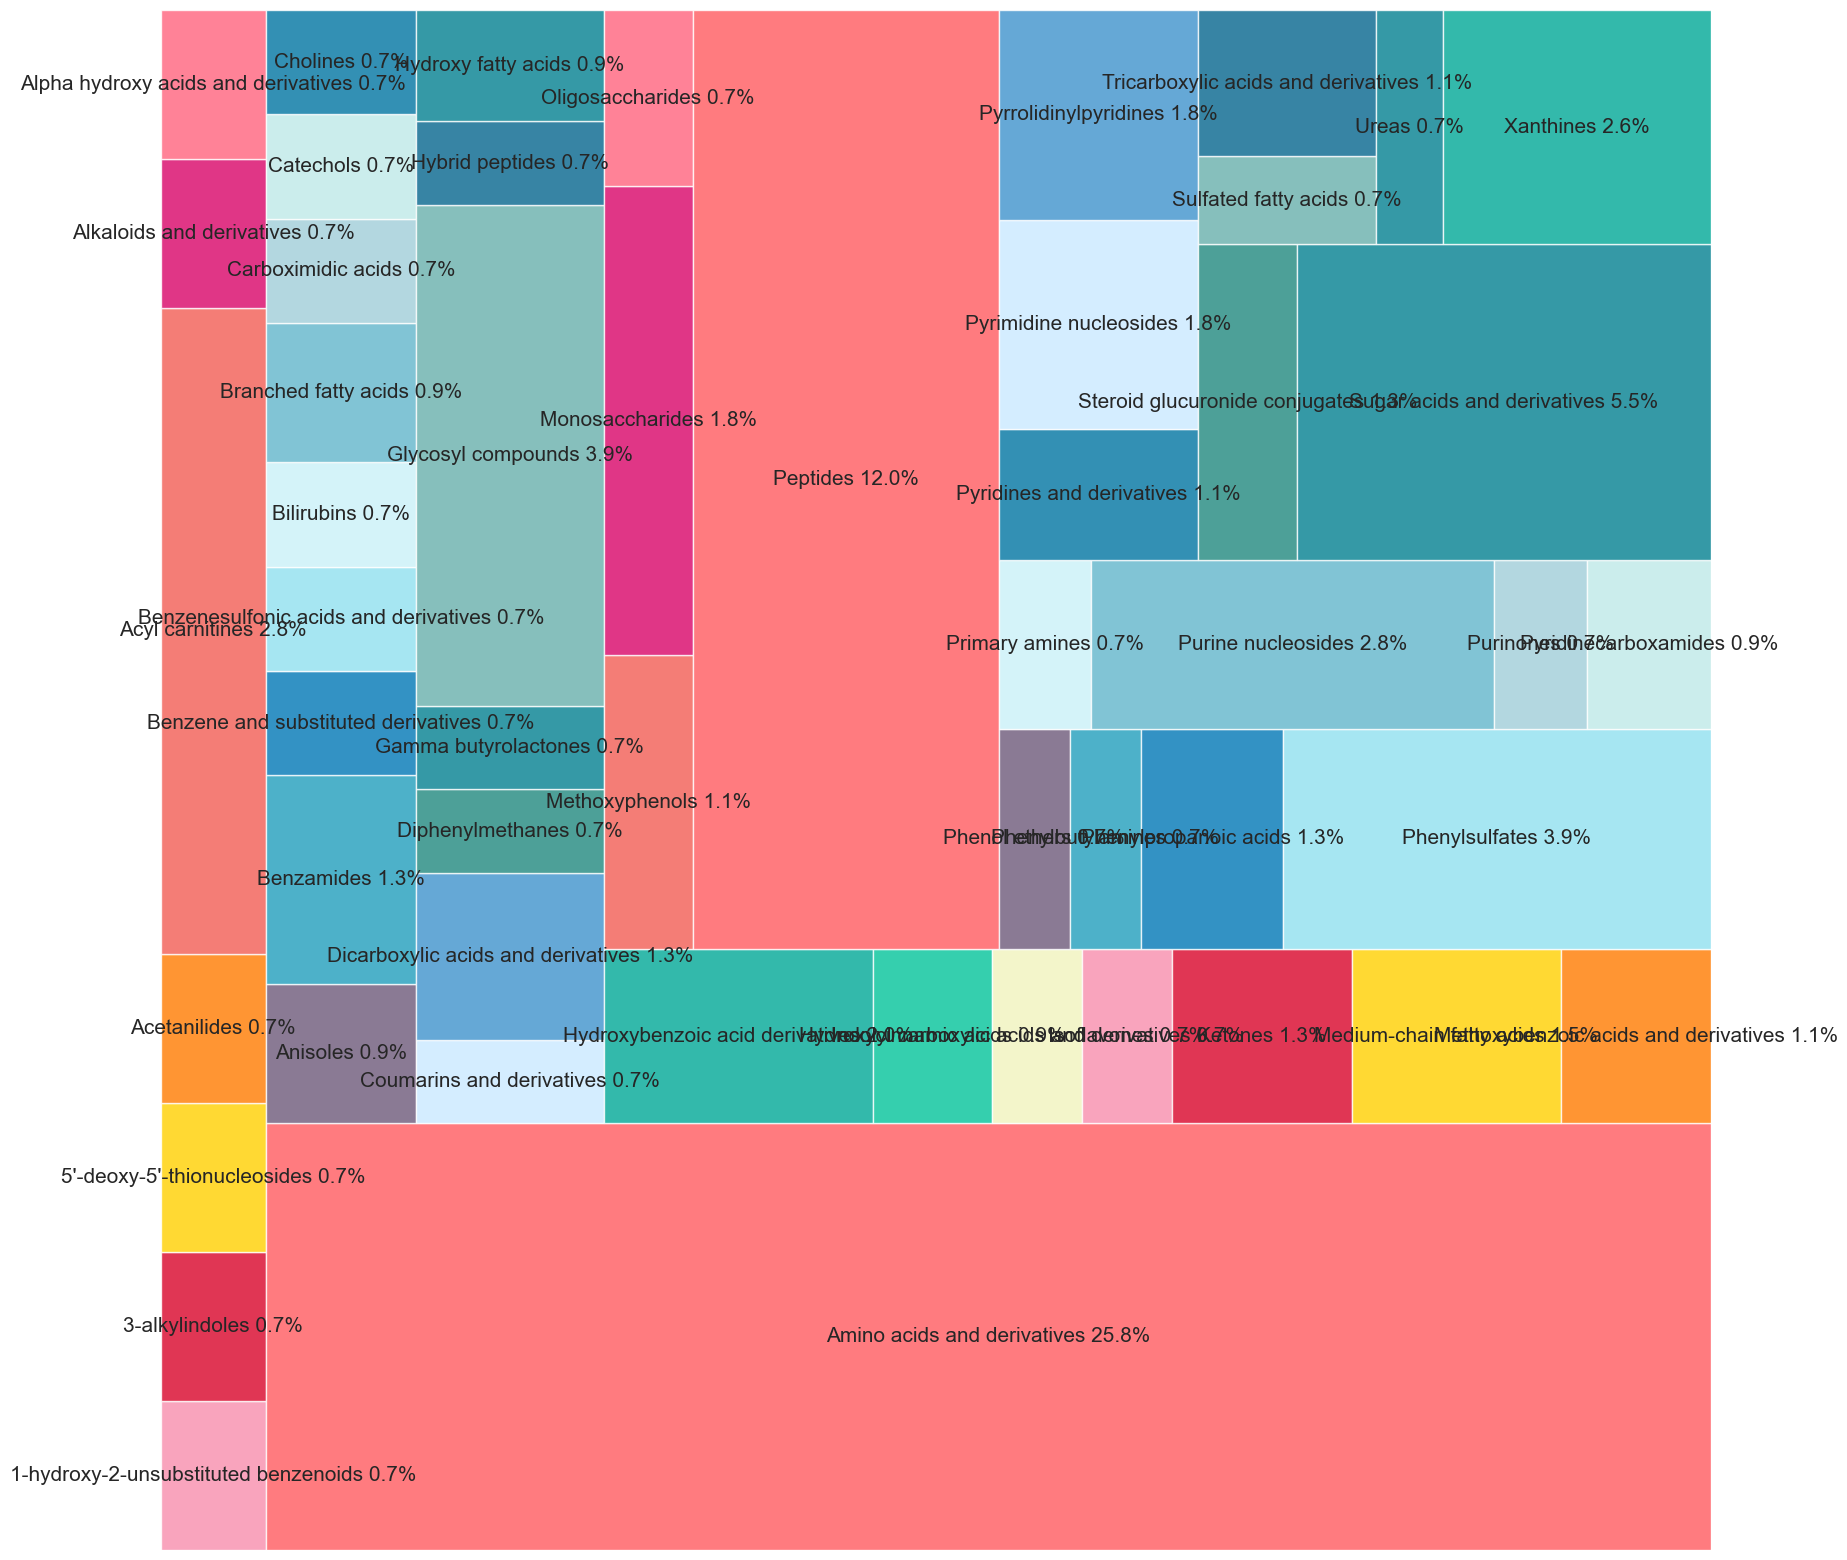

In [14]:
quiltplot(labs, df, list(class_color_dict.values()))